In [2]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam_models.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from cam_models.utils.visualize import visualize, reverse_normalize

from dataset.dataset import TestDataset
from utils.transforms import get_transform
from model.resnet import model_conv
from config import *

In [3]:
test_data = TestDataset(
    root="data/images/images",
    img_list="data/sample_sub_v2.csv",
    transforms=get_transform(False),
)
len(test_data)

509

data/images/images
aadawlxbmapqrblgxyzarhjasgiobu.png
tensor([[[0.2314, 0.2588, 0.2863,  ..., 0.0784, 0.0706, 0.0863],
         [0.2392, 0.2588, 0.2863,  ..., 0.1412, 0.1020, 0.1059],
         [0.2196, 0.2431, 0.2745,  ..., 0.2314, 0.1922, 0.1922],
         ...,
         [0.3647, 0.3686, 0.3882,  ..., 0.0784, 0.1490, 0.2353],
         [0.4078, 0.3882, 0.3725,  ..., 0.0235, 0.0549, 0.0941],
         [0.3647, 0.2824, 0.3373,  ..., 0.0000, 0.0000, 0.0078]],

        [[0.2157, 0.2431, 0.2745,  ..., 0.1020, 0.0980, 0.1098],
         [0.2235, 0.2471, 0.2784,  ..., 0.1490, 0.1098, 0.1137],
         [0.2078, 0.2392, 0.2706,  ..., 0.2196, 0.1804, 0.1804],
         ...,
         [0.4431, 0.4431, 0.4627,  ..., 0.0431, 0.1098, 0.2039],
         [0.4863, 0.4588, 0.4392,  ..., 0.0157, 0.0510, 0.0863],
         [0.4863, 0.3765, 0.4157,  ..., 0.0118, 0.0196, 0.0235]],

        [[0.1882, 0.2039, 0.2235,  ..., 0.0353, 0.0275, 0.0431],
         [0.1922, 0.2039, 0.2196,  ..., 0.0902, 0.0549, 0.0588],
    

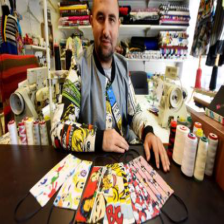

In [4]:
print(test_data[0])
print(len(test_data))
print(test_data[0][0].shape)
img = test_data[1]
print(img.shape)

Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [5]:
tensor_img = img.unsqueeze(0)
tensor_img.shape

torch.Size([1, 3, 224, 224])

In [6]:
# Load model from previous training
load_flag = True
if load_flag:
    model_conv.load_state_dict(torch.load("resnet_v3.pth"))

print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
model_conv.eval()
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# the target layer you want to visualize
model_conv.cpu()
target_layer = model_conv.layer4[1].conv2

# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
# wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model_conv, target_layer, n_samples=25, stdev_spread=0.15)

In [9]:
tensor_img

tensor([[[[0.5255, 0.5961, 0.6275,  ..., 0.0902, 0.3922, 0.8157],
          [0.5255, 0.5608, 0.6392,  ..., 0.1216, 0.4275, 0.8275],
          [0.5725, 0.5451, 0.6314,  ..., 0.1176, 0.5020, 0.8667],
          ...,
          [0.1569, 0.1569, 0.1569,  ..., 0.1137, 0.1059, 0.1020],
          [0.1529, 0.1529, 0.1529,  ..., 0.1137, 0.1059, 0.1020],
          [0.1529, 0.1529, 0.1529,  ..., 0.1137, 0.1059, 0.1020]],

         [[0.4706, 0.5333, 0.5569,  ..., 0.0980, 0.4275, 0.8706],
          [0.4745, 0.5020, 0.5647,  ..., 0.1333, 0.4627, 0.8706],
          [0.5216, 0.4863, 0.5686,  ..., 0.1255, 0.5333, 0.9020],
          ...,
          [0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0627, 0.0588],
          [0.0863, 0.0863, 0.0863,  ..., 0.0706, 0.0627, 0.0588],
          [0.0863, 0.0863, 0.0863,  ..., 0.0706, 0.0627, 0.0588]],

         [[0.3294, 0.3843, 0.4000,  ..., 0.0039, 0.2431, 0.6157],
          [0.3373, 0.3608, 0.4235,  ..., 0.0314, 0.2784, 0.6392],
          [0.4000, 0.3608, 0.4431,  ..., 0

In [10]:
print(device)
tensor_img.cpu()
target_layer.cpu()
cam, idx = wrapped_model(tensor_img)

cuda


C:\Users\HP\anaconda3\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 0	 probability 0.8863363265991211


In [11]:
print(cam.shape)
#Image.fromarray(cam.squeeze().mul(255).permute(1, 2, 0).byte().numpy())

torch.Size([1, 1, 7, 7])


torch.Size([1, 1, 7, 7])


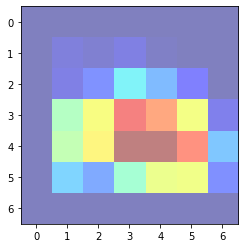

In [12]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
print(cam.shape)

In [13]:
# reverse normalization for display
img = reverse_normalize(tensor_img)
tensor_img

tensor([[[[0.6053, 0.6215, 0.6287,  ..., 0.5057, 0.5748, 0.6718],
          [0.6053, 0.6134, 0.6314,  ..., 0.5128, 0.5829, 0.6745],
          [0.6161, 0.6098, 0.6296,  ..., 0.5119, 0.5999, 0.6835],
          ...,
          [0.5209, 0.5209, 0.5209,  ..., 0.5110, 0.5092, 0.5083],
          [0.5200, 0.5200, 0.5200,  ..., 0.5110, 0.5092, 0.5083],
          [0.5200, 0.5200, 0.5200,  ..., 0.5110, 0.5092, 0.5083]],

         [[0.5614, 0.5755, 0.5807,  ..., 0.4780, 0.5517, 0.6510],
          [0.5623, 0.5684, 0.5825,  ..., 0.4859, 0.5597, 0.6510],
          [0.5728, 0.5649, 0.5834,  ..., 0.4841, 0.5755, 0.6580],
          ...,
          [0.4744, 0.4744, 0.4744,  ..., 0.4718, 0.4701, 0.4692],
          [0.4753, 0.4753, 0.4753,  ..., 0.4718, 0.4701, 0.4692],
          [0.4753, 0.4753, 0.4753,  ..., 0.4718, 0.4701, 0.4692]],

         [[0.4801, 0.4925, 0.4960,  ..., 0.4069, 0.4607, 0.5445],
          [0.4819, 0.4872, 0.5013,  ..., 0.4131, 0.4686, 0.5498],
          [0.4960, 0.4872, 0.5057,  ..., 0

torch.Size([1, 3, 224, 224])


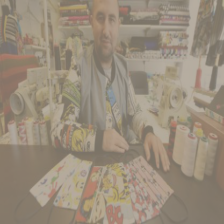

In [14]:
print(tensor_img.shape)
#Image.fromarray(tensor_img.squeeze().mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(img.squeeze().mul(255).permute(1, 2, 0).byte().numpy())

In [15]:
heatmap = visualize(img, cam)
heatmap

tensor([[[[0.3532, 0.3626, 0.3668,  ..., 0.2950, 0.3354, 0.3919],
          [0.3532, 0.3579, 0.3684,  ..., 0.2992, 0.3401, 0.3935],
          [0.3595, 0.3558, 0.3673,  ..., 0.2987, 0.3500, 0.3988],
          ...,
          [0.3039, 0.3039, 0.3039,  ..., 0.2982, 0.2971, 0.2966],
          [0.3034, 0.3034, 0.3034,  ..., 0.2982, 0.2971, 0.2966],
          [0.3034, 0.3034, 0.3034,  ..., 0.2982, 0.2971, 0.2966]],

         [[0.3275, 0.3357, 0.3388,  ..., 0.2789, 0.3219, 0.3798],
          [0.3281, 0.3316, 0.3398,  ..., 0.2835, 0.3265, 0.3798],
          [0.3342, 0.3296, 0.3404,  ..., 0.2824, 0.3357, 0.3839],
          ...,
          [0.2768, 0.2768, 0.2768,  ..., 0.2753, 0.2742, 0.2737],
          [0.2773, 0.2773, 0.2773,  ..., 0.2753, 0.2742, 0.2737],
          [0.2773, 0.2773, 0.2773,  ..., 0.2753, 0.2742, 0.2737]],

         [[0.5730, 0.5802, 0.5822,  ..., 0.5302, 0.5616, 0.6106],
          [0.5740, 0.5771, 0.5853,  ..., 0.5339, 0.5663, 0.6136],
          [0.5822, 0.5771, 0.5879,  ..., 0

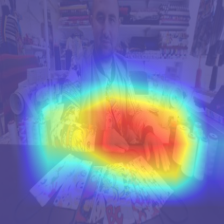

In [16]:
#hm = (heatmap.squeeze().numpy().transpose(1, 2, 0)).astype(np.int32)
#imshow(hm)
Image.fromarray(heatmap.squeeze().mul(255).permute(1, 2, 0).byte().numpy())

In [17]:
print(cam.shape)
Image.fromarray(cam.squeeze().mul(255).permute(1, 2, 0).byte().numpy())

torch.Size([1, 1, 7, 7])


RuntimeError: number of dims don't match in permute